In [1]:
import random

class Walk:
    def __init__(self, n_states):
        self.n_states = n_states
        self.terminal_state = -1
        self.initial_state = n_states // 2

    def step(self, state, action):
        if state < 0 or state >= self.n_states:
            raise ValueError("State out of bounds")

        if action not in [-1, 1]:
            raise ValueError("Invalid action. Action must be -1 (left) or 1 (right)")
        
        next_state = state + action

        if next_state >= self.n_states:
            return self.terminal_state, 1.0
        
        return next_state, 0.0
    
    def non_terminal_states(self):
        return [i for i in range(self.n_states) if i != self.terminal_state]
    
    def is_terminal(self, state):
        return state == self.terminal_state

In [2]:
class Policy:
    def __init__(self, env: Walk):
        self.env = env
        
    def probabilities(self, state):
        pass

    def probability(self, state, action):
        pass

    def take_action(self, state):
        pass
    
class RandomPolicy(Policy):
    def __init__(self, env: Walk):
        super().__init__(env)
        self.actions = [-1, 1]
        self.non_terminal_states = env.non_terminal_states()
        self._probabilities = {state: {action: 0.5 for action in self.actions} for state in self.non_terminal_states}
    
    def probabilities(self, state):
        return self._probabilities[state]
    
    def probability(self, state, action):
        return self._probabilities[state][action]
    
    def take_action(self, state):
        if state not in self.non_terminal_states:
            raise ValueError("State is terminal")
        
        action = random.choice(self.actions)
        return action
    
    def __call__(self, state, action=None):
        if action is None:
            return self.probabilities(state)
        else:
            return self.probability(state, action)
        
    

class DeterministicPolicy(Policy):
    def __init__(self, env: Walk):
        super().__init__(env)
        self.actions = [-1, 1]
        self.non_terminal_states = env.non_terminal_states()
        self._probabilities = {state: {-1: 0.0, 1:1.0} for state in self.non_terminal_states}
    
    def probabilities(self, state):
        return self._probabilities[state]
    
    def probability(self, state, action):
        return self._probabilities[state][action]
    
    def __call__(self, state, action=None):
        if action is None:
            return self.probabilities(state)
        else:
            return self.probability(state, action)

In [ ]:
from tqdm import tqdm
import numpy as np


def G_control_variate(
    t, h, states, actions, rewards, gamma, V, target_policy, behavior_policy
):
    if t == len(states) - 1:
        return V[states[t]]

    rho_t = target_policy.probability(
        states[t], actions[t]
    ) / behavior_policy.probability(states[t], actions[t])

    return rho_t * (
        rewards[t+1]
        + gamma
        * G_control_variate(
            t + 1, h, states, actions, rewards, gamma, V, target_policy, behavior_policy
        )
    ) + (1 - rho_t) * V[states[t]]


def n_step_TD_prediction(
    env,
    n,
    target_policy,
    behavior_policy,
    alpha=0.1,
    gamma=1,
    num_episodes=1000,
    progress_bar=True,
    per_decision_importance_sampling=False,
):
    V = [0.5] * env.n_states + [0.0]
    V = np.array(V)
    history = []

    if progress_bar:
        episodes_range = tqdm(range(num_episodes))
    else:
        episodes_range = range(num_episodes)

    for episode in episodes_range:
        state = env.initial_state

        T = float("inf")
        t = -1
        states = [state]
        actions = []
        rewards = [0.0]

        while True:
            t += 1
            if t < T:
                state = states[t]
                action = behavior_policy.take_action(state)
                actions.append(action)

                next_state, reward = env.step(state, action)
                states.append(next_state)
                rewards.append(reward)

                if env.is_terminal(next_state):
                    T = t + 1

            t_update = t - n + 1

            if t_update >= 0:
                if per_decision_importance_sampling:
                    G = G_control_variate(
                        t_update,
                        t_update + n - 1,
                        states,
                        actions,
                        rewards,
                        gamma,
                        V,
                        target_policy,
                        behavior_policy,
                    )

                    V[states[t_update]] += (
                        alpha * (G - V[states[t_update]])
                    )

                else:
                    importance_sampling_ratio = 1.0
                    for i in range(t_update, min(t_update + n, T - 1)):
                        importance_sampling_ratio *= target_policy.probability(
                            states[i], actions[i]
                        ) / behavior_policy.probability(states[i], actions[i])

                    G = sum(
                        gamma ** (i - t_update - 1) * rewards[i]
                        for i in range(t_update + 1, min(t_update + n, T) + 1)
                    )

                    if t_update + n < T:
                        G += gamma**n * V[states[t_update + n]]

                    V[states[t_update]] += (
                        importance_sampling_ratio * alpha * (G - V[states[t_update]])
                    )

            if t_update == T - 1:
                break

        history.append(V.copy()[:-1])

    return V[:-1], history

In [183]:
def mean_squared_error(predicted, true, axis=None):
    return np.mean((predicted - true) ** 2, axis=axis)

In [189]:
n = 2
env = Walk(5)
target_policy = DeterministicPolicy(env)
behavior_policy = RandomPolicy(env)

histories_normal = []
histories_per_decision = []    

for i in range(10):
    v_normal, history_normal = n_step_TD_prediction(
        env,
        n,
        target_policy,
        behavior_policy,
        num_episodes=20,
        per_decision_importance_sampling=False,
        progress_bar=False
    )

    v_per_decision, history_per_decision = n_step_TD_prediction(
        env,
        n,
        target_policy,
        behavior_policy,
        num_episodes=20,
        per_decision_importance_sampling=True,
        progress_bar=False
    )

    histories_per_decision.append(history_per_decision)

    histories_normal.append(history_normal)

In [190]:
histories_normal = np.array(histories_normal)
histories_per_decision = np.array(histories_per_decision)

In [191]:
mean_squared_error_per_episodes_normal = mean_squared_error(np.array(histories_normal), 1, axis=(0, 2))
mean_squared_error_per_episodes_per_decision = mean_squared_error(np.array(histories_per_decision), 1, axis=(0, 2))

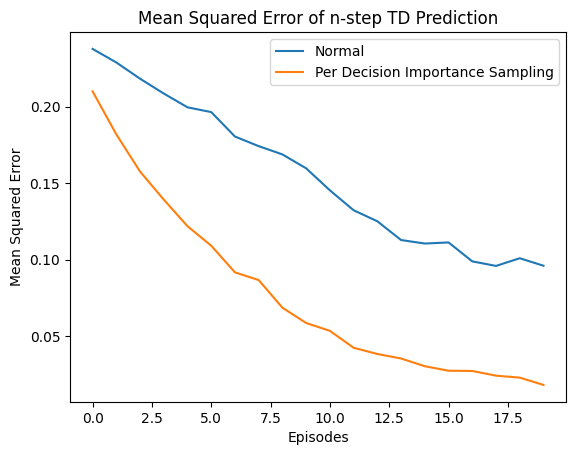

In [192]:
import matplotlib.pyplot as plt

plt.plot(mean_squared_error_per_episodes_normal, label="Normal")
plt.plot(mean_squared_error_per_episodes_per_decision, label="Per Decision Importance Sampling")
plt.xlabel("Episodes")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error of n-step TD Prediction")
plt.legend()
plt.show()